## Trying out a linear model and then try to turn the parameters for xgboost
Author: Shuai Ma <mashuai_191@163.com>
 
This note copy big part of code from [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models)
 and got most of insight about tuning xgboost parameters from [Complete Guide to Parameter Tuning in XGBoost (with codes in Python)](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [3]:
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

train["SalePrice"] = np.log1p(train["SalePrice"])


all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

# Feature engineering (Clean up)
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
all_data["GarageType"] = all_data["GarageType"].fillna("None")
all_data["GarageFinish"] = all_data["GarageFinish"].fillna("None")
all_data["GarageQual"] = all_data["GarageQual"].fillna("None")
all_data["GarageCond"] = all_data["GarageCond"].fillna("None")
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

# Feature engineering (Transform)
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['YearBuilt'] = all_data['YearBuilt'].astype(str)
all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str)
#all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)


from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold', 'YearBuilt', 'YearRemodAdd')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape 
print('Shape all_data: {}'.format(all_data.shape))

# Adding total sqfootage feature 
all_data['TotalSF'] = pd.Series(all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'])



Shape all_data: (2917, 78)


###Data preprocessing: 
We're not going to do anything fancy here: 
 
- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9fd4f6908>,
      dtype=object)

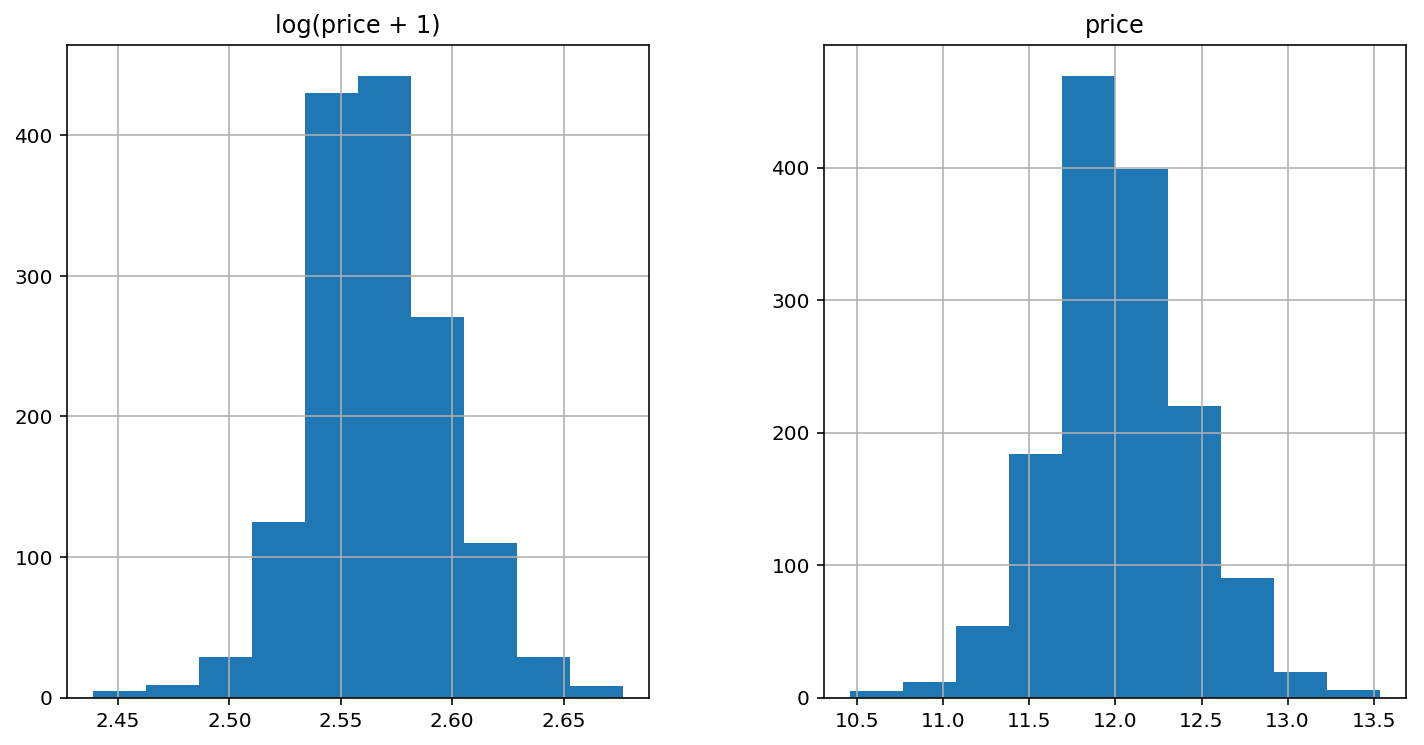

In [4]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [5]:
#log transform the target:
#train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[abs(skewed_feats) > 0.5]
skewed_feats = skewed_feats.index

#use box cox instead of log1
print("There are {} skewed numerical features to Box Cox transform".format(skewed_feats.shape[0]))
from scipy.special import boxcox1p
lam = 0.15
for feat in skewed_feats:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
#all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

There are 47 skewed numerical features to Box Cox transform


In [6]:
all_data = pd.get_dummies(all_data)

In [7]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [8]:
from sklearn.preprocessing import StandardScaler

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice


# try to find outliers
#import statsmodels.api as sm

#ols = sm.OLS(endog = y, exog = X_train)
#fit = ols.fit()
#test2 = fit.outlier_test()['bonf(p)']
#outliers = list(test2[test2<1e-3].index) 
outliers = [462, 632, 1324, 1370, 1453]
print (outliers)

X_train = X_train.drop(X_train.index[outliers])
y = y.drop(y.index[outliers])

# find big mean columns and then normalize them with standard deviation
big_col = (X_train.mean() > 100).index
tmp_mean = X_train[big_col].mean().sort_values(ascending=False)

stdSc = StandardScaler()
X_train.loc[:, ["GarageArea"]] = stdSc.fit_transform(X_train.loc[:, ["GarageArea"]])
X_test.loc[:, ["GarageArea"]] = stdSc.transform(X_test.loc[:, ["GarageArea"]])

[462, 632, 1324, 1370, 1453]


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


###Models

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [9]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [10]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

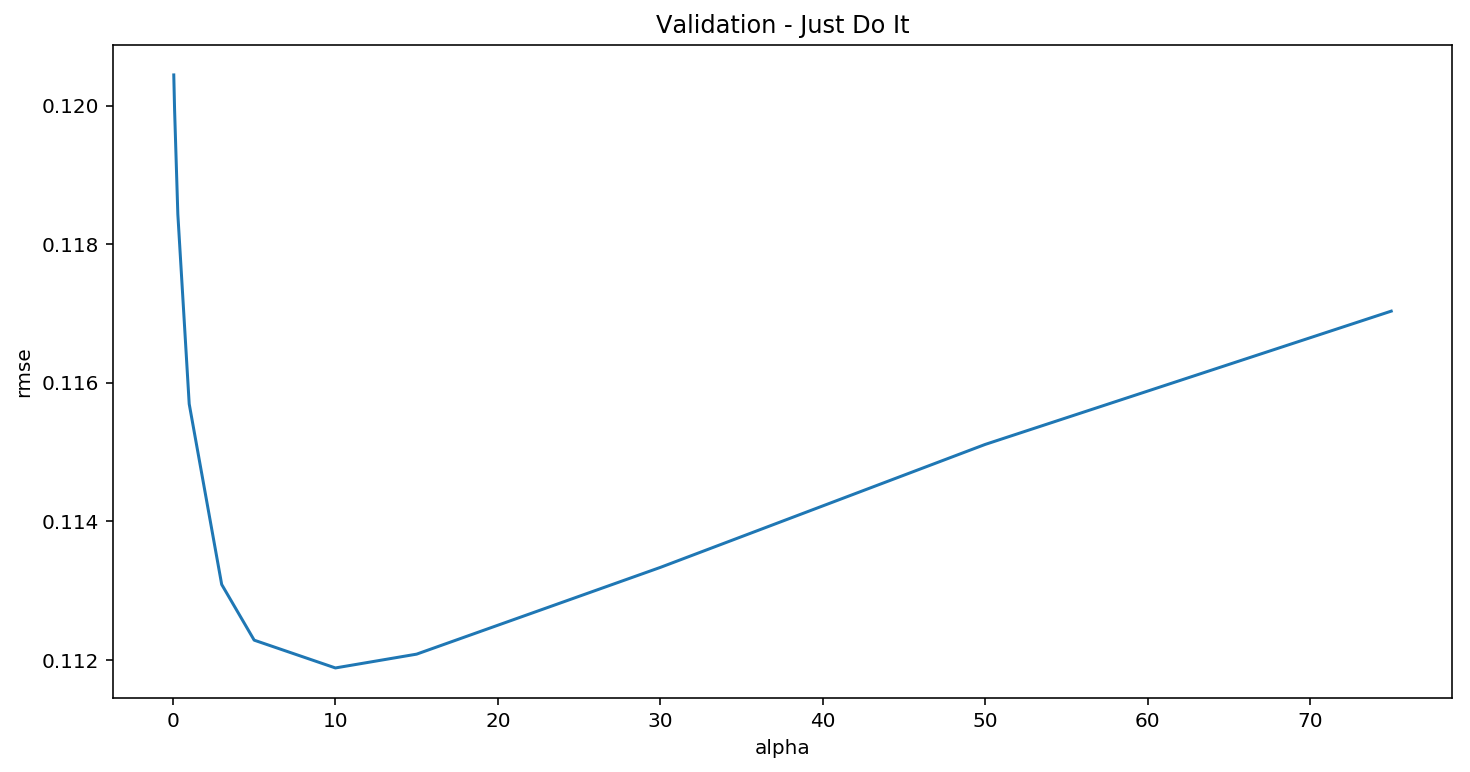

In [11]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [12]:
cv_ridge.min()

0.11188401993975597

So for the Ridge regression we get a rmsle of about 0.127

Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [13]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
alpha=model_lasso.alpha_
print (alpha)
model_lasso = LassoCV(alphas = [0.3*alpha, 0.5*alpha, alpha, 1.5*alpha]).fit(X_train, y)
print (model_lasso.alpha_)


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.0005
0.0005


In [14]:
rmse_cv(model_lasso).mean()

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

0.10968359797323783

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [15]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print (coef.min())

-0.2661454756308282


In [16]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
print("Lasso picked " + str(sum(coef > 0)) + " + variables and picked " +  str(sum(coef < 0)) + " - variables")

Lasso picked 97 variables and eliminated the other 123 variables
Lasso picked 56 + variables and picked 41 - variables


Good job Lasso.  One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [17]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

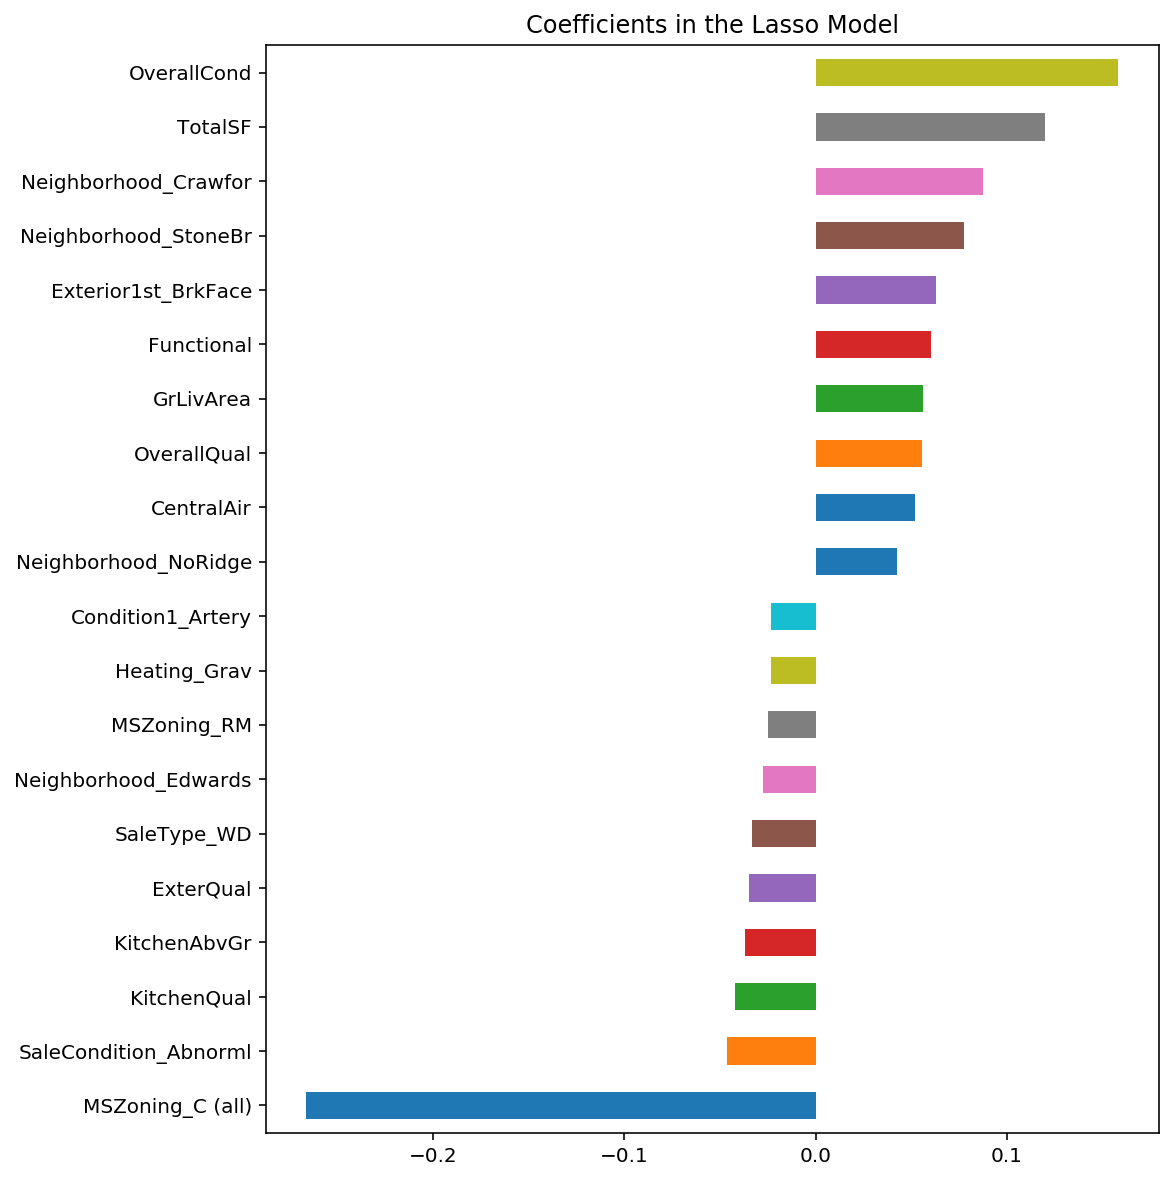

In [18]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is `GrLivArea` -  the above ground area by area square feet. This definitely sense. Then a few other  location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

 Also note that unlike the feature importance you'd get from a random forest these are _actual_ coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret. 

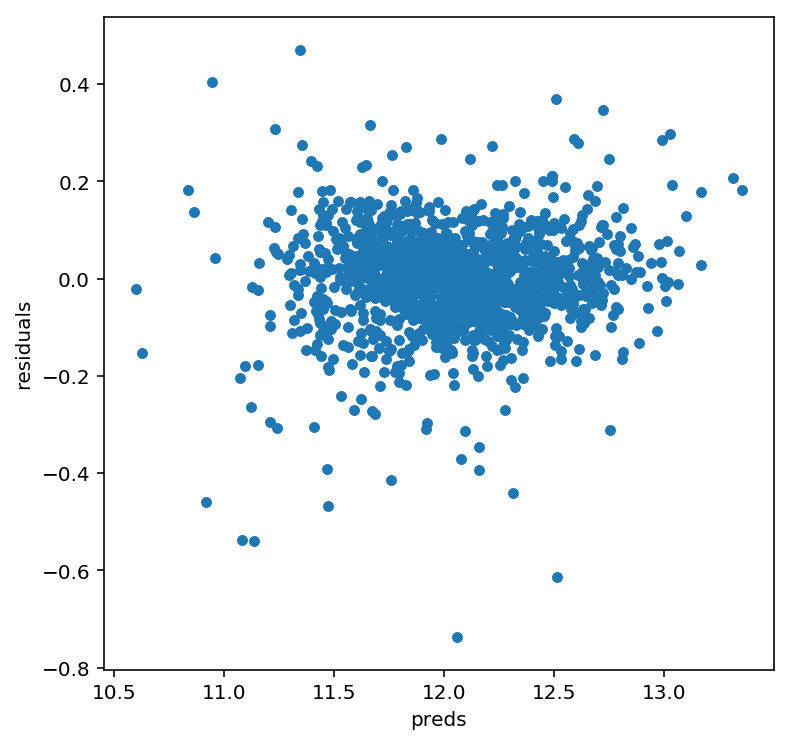

In [19]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")


The residual plot looks pretty good.To wrap it up let's predict on the test set and submit on the leaderboard:

### Tune a KRR model


In [20]:
from sklearn.kernel_ridge import KernelRidge

param_test1 = {
 'alpha':[0.83, 0.84, 0.85]
}
print (param_test1)
gsearch1 = GridSearchCV(estimator = KernelRidge( alpha=0.1, kernel='polynomial', degree=2, coef0=2.5), 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch1.fit(X_train,y)
gsearch1.cv_results_['mean_test_score'], gsearch1.best_params_, gsearch1.best_score_


{'alpha': [0.83, 0.84, 0.85]}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   11.5s finished


(array([-0.01457463, -0.01457449, -0.01457449]),
 {'alpha': 0.84},
 -0.014574489127861487)

### Adding an xgboost model:

Let's add an xgboost model to our linear model to see if we can improve our score:

In [21]:
stop

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 24, 8

train = X_train
test = X_test
y = y



NameError: name 'stop' is not defined

In [22]:

#dtrain = xgb.DMatrix(X_train, label = y)
#dtest = xgb.DMatrix(X_test)

#params = {"max_depth":2, "eta":0.1}
#model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    print ("n_estimators", alg.get_params()['n_estimators'])
    alg.fit(dtrain[predictors], y, eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("Model Report")
    #print ("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y.values, dtrain_predictions)))

    print (rmse_cv(alg).mean(), "--", rmse_cv(alg))
    


In [23]:
#print (model.tail())
#model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
#Choose all predictors except target & IDcols

predictors = [x for x in train.columns]
xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, train, predictors, useTrainCV=True)



ValueError: could not convert string to float: 'RL'

In [24]:
param_test1 = {
 'max_depth':[2,3,4],
 'min_child_weight':[1,2,3,4]
}
print (param_test1)
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=337, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=None, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch1.fit(train[predictors],y)
gsearch1.cv_results_['mean_test_score'], gsearch1.best_params_, gsearch1.best_score_

#result is 3, 3

{'max_depth': [2, 3, 4], 'min_child_weight': [1, 2, 3, 4]}


ValueError: Found input variables with inconsistent numbers of samples: [1458, 1453]

In [25]:
# tune gamma

param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
print (param_test2)
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=337, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=None, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch1.fit(train[predictors],y)
gsearch1.cv_results_['mean_test_score'], gsearch1.best_params_, gsearch1.best_score_



{'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}


ValueError: Found input variables with inconsistent numbers of samples: [1458, 1453]

In [26]:
#re-calibrate the number of boosting rounds for the updated parameters.
predictors = [x for x in train.columns]
xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, train, predictors, useTrainCV=True)
# result is
#n_estimators 344


ValueError: could not convert string to float: 'RL'

In [27]:
# tune subsample and colsample_bytree

param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
print (param_test3)
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=389, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=None, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch1.fit(train[predictors],y)
gsearch1.cv_results_['mean_test_score'], gsearch1.best_params_, gsearch1.best_score_


{'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}


ValueError: Found input variables with inconsistent numbers of samples: [1458, 1453]

In [28]:
# fne tune subsample and colsample_bytree 

param_test4 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
print (param_test4)
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=389, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=None, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch1.fit(train[predictors],y)
gsearch1.cv_results_['mean_test_score'], gsearch1.best_params_, gsearch1.best_score_



{'subsample': [0.75, 0.8, 0.85], 'colsample_bytree': [0.75, 0.8, 0.85]}


ValueError: Found input variables with inconsistent numbers of samples: [1458, 1453]

In [29]:
# tune regularization parameters
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
print (param_test5)
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=389, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=None, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch1.fit(train[predictors],y)
gsearch1.cv_results_['mean_test_score'], gsearch1.best_params_, gsearch1.best_score_

{'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]}


ValueError: Found input variables with inconsistent numbers of samples: [1458, 1453]

In [30]:
param_test6 = {
 'reg_alpha':[1e-06, 1.5e-06, 1e-05, 1.5e-05]
}
print (param_test6)
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=389, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=None, scale_pos_weight=1, seed=27), 
 param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch1.fit(train[predictors],y)
gsearch1.cv_results_['mean_test_score'], gsearch1.best_params_, gsearch1.best_score_

{'reg_alpha': [1e-06, 1.5e-06, 1e-05, 1.5e-05]}


ValueError: Found input variables with inconsistent numbers of samples: [1458, 1453]

In [31]:
param_test7 = {
 'reg_lambda':[0.5, 1, 1.5, 2, 3]
}
print (param_test7)
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=389, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=None, scale_pos_weight=1, seed=27, reg_alpha=1.5e-05), 
 param_grid = param_test7, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch1.fit(train[predictors],y)
gsearch1.cv_results_['mean_test_score'], gsearch1.best_params_, gsearch1.best_score_

{'reg_lambda': [0.5, 1, 1.5, 2, 3]}


ValueError: Found input variables with inconsistent numbers of samples: [1458, 1453]

In [32]:
predictors = [x for x in train.columns]
xgb3 = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha = 1.5e-05,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb3, train, predictors, useTrainCV=True)

# result is 2404


ValueError: could not convert string to float: 'RL'

In [33]:
feat_imp = pd.Series(xgb3.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

XGBoostError: need to call fit or load_model beforehand

In [34]:
model_xgb = XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [35]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

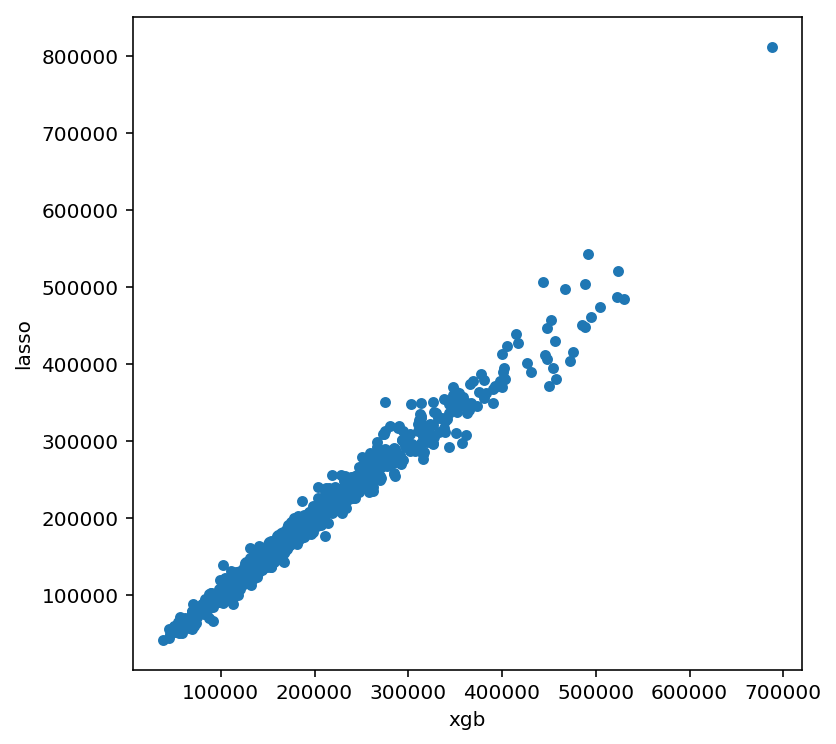

In [36]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves the score although in this case it doesn't help that much.

In [37]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [38]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

### Trying out keras?

Feedforward Neural Nets doesn't seem to work well at all...I wonder why.

In [39]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [40]:
X_train = StandardScaler().fit_transform(X_train)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [41]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [42]:
X_tr.shape

(1089, 220)

In [43]:
X_tr

array([[ 0.50560244,  0.51359376,  0.0565937 , ..., -0.11813862,
         0.46683827, -0.30410722],
       [-0.58801921,  0.47267023,  0.18623283, ..., -0.11813862,
         0.46683827, -0.30410722],
       [-0.58801921,  0.51359376,  0.20554632, ..., -0.11813862,
         0.46683827, -0.30410722],
       ...,
       [-1.40823546, -1.85769932, -2.45126338, ..., -0.11813862,
         0.46683827, -0.30410722],
       [ 2.14603493,  0.63380817, -0.48679513, ..., -0.11813862,
         0.46683827, -0.30410722],
       [ 0.77900786,  0.55408477,  0.67400559, ..., -0.11813862,
         0.46683827, -0.30410722]])

In [44]:
model = Sequential()
#model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=220, kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 221       
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [46]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 1089 samples, validate on 364 samples
Epoch 1/1
1089/1089 [==============================] - 3s 3ms/step - loss: 146.2728 - val_loss: 147.7177


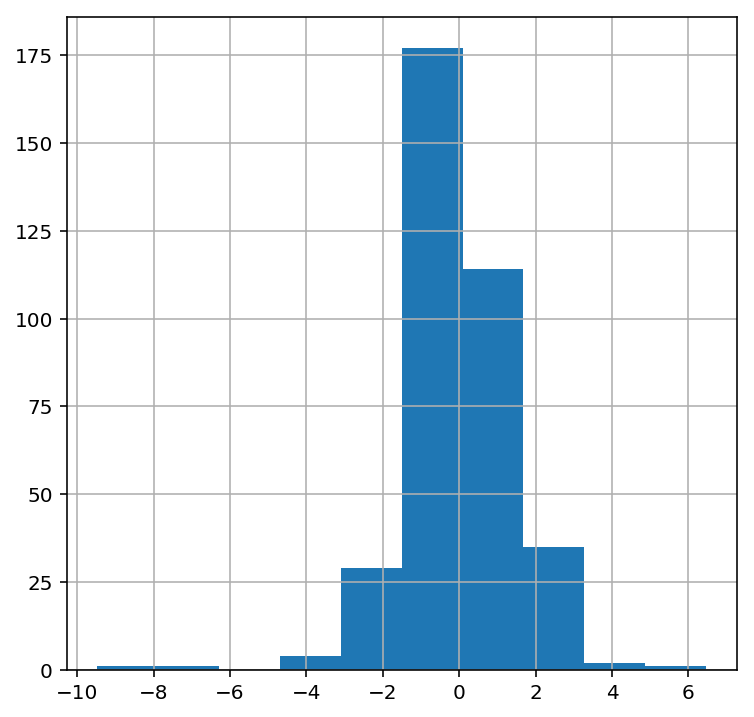

In [47]:
pd.Series(model.predict(X_val)[:,0]).hist()